
# 02 — Preprocessing

**Goal:** Prepare the Elliptic AML dataset for modeling by cleaning features, mapping labels, removing highly correlated columns, making a **time-aware** train/validation/test split, and standardizing features.  
This notebook is **self-contained** and does **not** depend on any external `.py` files.

**What you'll get out at the end:**
- Cleaned feature set with high-correlation columns removed
- Time-based train/valid/test splits
- Standardized feature matrices (`X_train`, `X_valid`, `X_test`) and labels
- Saved artifacts (splits, scaler, and metadata) for use in `03_modeling.ipynb`



## 1. Imports & Configuration

We import common libraries and set a fixed random seed for reproducibility.  
If a folder does not exist, we create it.


In [15]:

import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import joblib

# --- Reproducibility ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- Project paths (relative to this notebook) ---
DATA_RAW = Path("../data/raw")                     # put original CSVs here
DATA_INTERIM = Path("../data/interim")             # temporary outputs (IDs etc.)
DATA_PROCESSED = Path("../data/processed")         # processed data for modeling

for p in [DATA_INTERIM, DATA_PROCESSED]:
    p.mkdir(parents=True, exist_ok=True)

print("Raw:", DATA_RAW.resolve())
print("Interim:", DATA_INTERIM.resolve())
print("Processed:", DATA_PROCESSED.resolve())


Raw: /Users/o/Desktop/projects/elliptic-aml-analysis/data/raw
Interim: /Users/o/Desktop/projects/elliptic-aml-analysis/data/interim
Processed: /Users/o/Desktop/projects/elliptic-aml-analysis/data/processed



## 2. Load Data & Run Basic Integrity Checks

We expect three CSVs from the Elliptic dataset:

- `elliptic_txs_features.csv`
- `elliptic_txs_edgelist.csv`
- `elliptic_txs_classes.csv`

We check shapes, uniqueness of `txId`, and whether edge endpoints exist in the classes table.


In [16]:

# --- Load CSVs ---
features = pd.read_csv(DATA_RAW / "elliptic_txs_features.csv", header=None)
edges    = pd.read_csv(DATA_RAW / "elliptic_txs_edgelist.csv")
classes  = pd.read_csv(DATA_RAW / "elliptic_txs_classes.csv")

print("features:", features.shape)
print("edges:", edges.shape)
print("classes:", classes.shape)

# --- Basic checks ---
assert features.shape[0] == classes.shape[0], "Features and classes must have the same number of rows (aligned by txId)."
assert classes['txId'].is_unique, "txId should be unique in classes."

nulls = features.isna().sum().sum()
dups_edges = edges.duplicated().sum()
print(f"NULLs in features: {nulls}, duplicate edges: {dups_edges}")

# Ensure graph endpoints exist in the classes list
assert set(edges['txId1']).issubset(set(classes['txId'])), "Some txId1 are missing in classes."
assert set(edges['txId2']).issubset(set(classes['txId'])), "Some txId2 are missing in classes."

print("\nBasic integrity checks: OK ✅")


features: (203769, 167)
edges: (234355, 2)
classes: (203769, 2)
NULLs in features: 0, duplicate edges: 0

Basic integrity checks: OK ✅



## 3. Label Mapping (Binary Supervised Subset)

We map labels to **binary** targets for supervised learning:

- `1` (illicit) → `1`
- `2` (licit) → `0`
- `unknown` → dropped for the **supervised** subset

We keep a separate mask so that you can build semi-supervised methods later (in other notebooks) using the full dataset.


In [17]:

# Attach txId to features so we can track rows after filtering
features = features.copy()
features['txId'] = classes['txId']

# Map original labels to {1: illicit, 0: licit}, unknown -> NaN
label_map = {'1':1, 1:1, '2':0, 2:0, 'unknown':np.nan}
y_raw = classes['class'].map(label_map)

# Build supervised subset (drop unknowns)
mask_sup = y_raw.notna()
y_sup = y_raw[mask_sup].astype(int).reset_index(drop=True)
feat_sup = features.loc[mask_sup].reset_index(drop=True)

print("Supervised subset size:", feat_sup.shape, "; Positives:", int((y_sup==1).sum()), "; Negatives:", int((y_sup==0).sum()))


Supervised subset size: (46564, 168) ; Positives: 4545 ; Negatives: 42019



## 4. Feature Cleaning

**Why?** In AML datasets, many features are anonymized and some may be near-duplicate (highly correlated).  
Removing constant/near-zero-variance and **very** highly correlated features helps reduce redundancy and improves model stability.

**Steps:**
1. Drop constant columns.
2. Drop one of any pair of features whose absolute correlation > **0.98**.


In [18]:

# Numeric columns (all except txId, which we added at the end)
num_cols = [c for c in feat_sup.columns if c != 'txId']

# 1) Drop constant columns
nunique = feat_sup[num_cols].nunique()
keep = nunique[nunique > 1].index.tolist()
feat_sup = feat_sup[['txId'] + keep]

# 2) Drop highly correlated columns (> 0.98)
X = feat_sup.drop(columns=['txId'])
corr = X.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.98)]
feat_sup = feat_sup.drop(columns=to_drop)

print(f"Dropped {len(to_drop)} highly correlated columns (threshold=0.98). Remaining features: {feat_sup.shape[1]-1}")


Dropped 46 highly correlated columns (threshold=0.98). Remaining features: 121



### Quick Visualization: Correlation Heatmap (Before vs After)

We compare correlation structure **before** and **after** dropping highly correlated features.  
For readability, we only plot the **first 40 columns**.


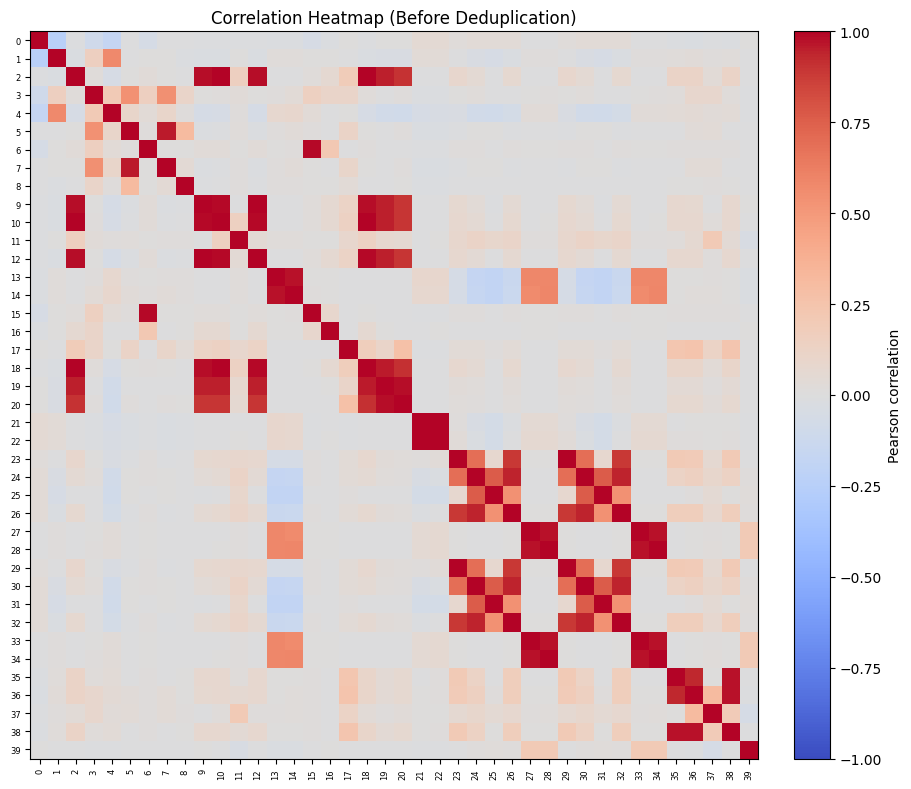

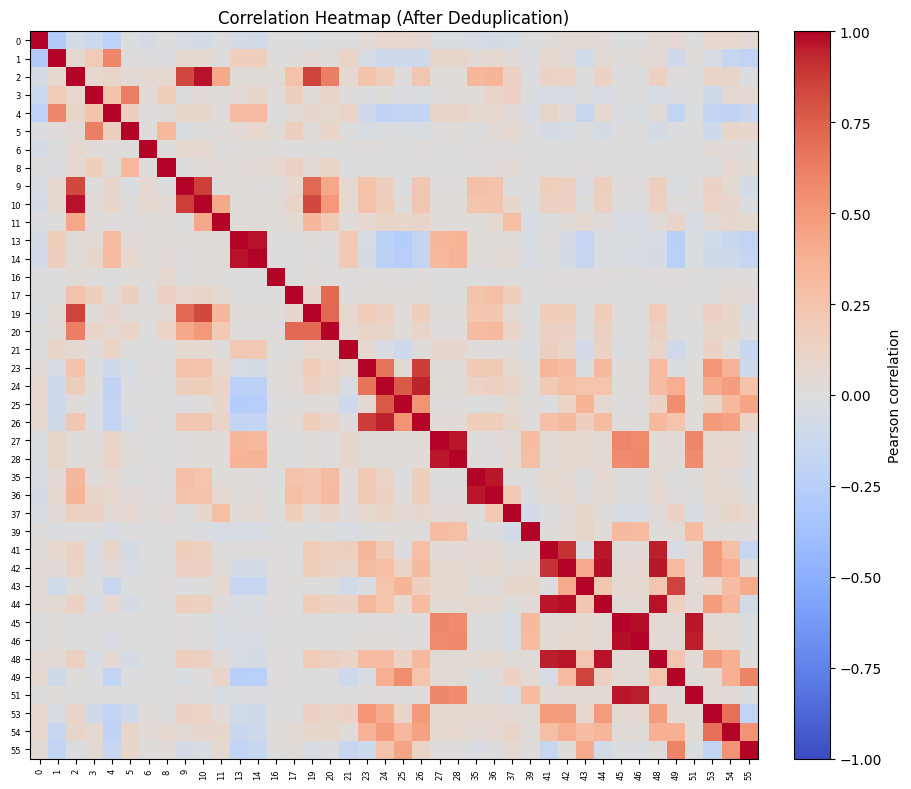

,n_features_before,n_features_after,memory_before_MB,memory_after_MB,mean_abs_corr_before,mean_abs_corr_after
0,167,121,259.62,42.99,0.074438,0.087468


In [28]:
# === Correlation heatmap before vs after deduplication ===
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Rebuild a "before deduplication" feature matrix from raw data
feat_rebuild = features.copy()
feat_rebuild['txId'] = classes['txId']

num_cols0 = [c for c in feat_rebuild.columns if c != 'txId']
nunique0 = feat_rebuild[num_cols0].nunique()
keep0 = nunique0[nunique0 > 1].index.tolist()

feat_before = feat_rebuild[['txId'] + keep0].copy()
X_before = feat_before.drop(columns=['txId'])

# 2) Use the already deduplicated feature matrix as "after"
X_after = feat_sup.drop(columns=['txId'])

# 3) Function to plot correlation heatmap
def plot_corr_heatmap(X, title, max_cols=40):
    """
    Plot a correlation heatmap using the first `max_cols` features.
    Shows the full symmetric correlation matrix (not masked).
    """
    cols = X.columns[:max_cols]
    corr = X[cols].corr()

    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(title)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("Pearson correlation")
    plt.xticks(range(len(cols)), cols, rotation=90, fontsize=6)
    plt.yticks(range(len(cols)), cols, fontsize=6)
    plt.tight_layout()
    plt.show()

# 4) Plot before and after
plot_corr_heatmap(X_before, "Correlation Heatmap (Before Deduplication)")
plot_corr_heatmap(X_after, "Correlation Heatmap (After Deduplication)")

# 5) Simple comparison table: number of features, memory usage, mean correlation
def mem_mb(df): 
    return round(df.memory_usage(deep=True).sum() / 1024**2, 2)

compare = pd.DataFrame({
    "n_features_before": [X_before.shape[1]],
    "n_features_after":  [X_after.shape[1]],
    "memory_before_MB":  [mem_mb(X_before)],
    "memory_after_MB":   [mem_mb(X_after)],
    "mean_abs_corr_before": [float(np.nanmean(np.abs(X_before.corr().values)))],
    "mean_abs_corr_after":  [float(np.nanmean(np.abs(X_after.corr().values)))]
})
display(compare)


### Analysis of Correlation Heatmaps

#### Before Deduplication

- The diagonal red line shows self-correlation (=1).

- Several dense red clusters appear off the diagonal, indicating groups of features that are almost perfectly correlated (>0.98).

- Such redundancy often occurs in derived or anonymized datasets, where multiple indicators encode nearly identical information.

- Keeping them risks overfitting and slows down training without adding predictive power.

#### After Deduplication

- The redundant clusters largely disappear.

- The overall correlation structure becomes more sparse, with fewer near-perfect correlations.

- This confirms that 46 features were safely removed, leaving 121 unique signals.

#### Why It Matters

- Reducing multicollinearity improves model stability, especially for linear models and logistic regression.

- Training efficiency increases since models no longer waste resources learning from duplicate signals.

- The cleaned feature matrix now provides a stronger foundation for downstream fraud detection tasks.


## 5. Persist Results (Dropped List + Cleaned Features)

We save:
- the list of dropped columns  
- the cleaned feature table (Parquet preferred; fallback to CSV to avoid local engine issues)


In [21]:

# Save dropped columns list
dropped_path = DATA_PROCESSED / "dropped_highcorr_cols.txt"
with open(dropped_path, "w") as f:
    for col in to_drop:
        f.write(f"{col}\n")
print("Saved dropped columns list ->", dropped_path)

# Save cleaned features with fallback
out_feat = feat_sup.copy()
parquet_path = DATA_PROCESSED / "features_dedup.parquet"
csv_path     = DATA_PROCESSED / "features_dedup.csv"

# Normalize dtypes to avoid Arrow extension type issues
numeric_like = out_feat.select_dtypes(include=["number", "bool"]).columns.tolist()
for c in out_feat.columns:
    if c in numeric_like:
        out_feat[c] = pd.to_numeric(out_feat[c], errors="coerce")
    else:
        out_feat[c] = out_feat[c].astype("object")

saved = False
try:
    out_feat.to_parquet(parquet_path, index=False, engine="pyarrow")
    print("Saved Parquet (pyarrow) ->", parquet_path)
    saved = True
except Exception as e1:
    print("pyarrow failed:", repr(e1))
    try:
        out_feat.to_parquet(parquet_path, index=False, engine="fastparquet")
        print("Saved Parquet (fastparquet) ->", parquet_path)
        saved = True
    except Exception as e2:
        print("fastparquet failed:", repr(e2))

if not saved:
    out_feat.to_csv(csv_path, index=False)
    print("Fallback: saved CSV ->", csv_path)


Saved dropped columns list -> ../data/processed/dropped_highcorr_cols.txt
Saved Parquet (pyarrow) -> ../data/processed/features_dedup.parquet



## 6. Time-Aware Split (Train/Valid/Test)

The dataset has a **timestep** in the first feature column (`column 0`).  
We split by time to mimic real-world evaluation:

- Train: first 70% (by time)
- Valid: next 10%
- Test: last 20%


In [22]:

# Extract timestep from column 0 (please verify for your dataset version)
timestep_col = 0

df = feat_sup.copy()
df['timestep'] = df[timestep_col]

# Align labels with the supervised subset
df['label'] = y_sup

# Sort and split by time quantiles
df = df.sort_values('timestep').reset_index(drop=True)
ts = df['timestep'].values

t1 = np.quantile(ts, 0.7)
t2 = np.quantile(ts, 0.8)

train_idx = df['timestep'] <= t1
valid_idx = (df['timestep'] > t1) & (df['timestep'] <= t2)
test_idx  = df['timestep'] > t2

train = df.loc[train_idx].reset_index(drop=True)
valid = df.loc[valid_idx].reset_index(drop=True)
test  = df.loc[test_idx].reset_index(drop=True)

print("Train/Valid/Test sizes:", train.shape, valid.shape, test.shape)


Train/Valid/Test sizes: (32595, 124) (4656, 124) (9313, 124)



## 7. Standardization (Fit on Train Only)

We standardize numeric features with `StandardScaler` fitted **only on the training set** to avoid data leakage.


In [23]:

feature_cols = [c for c in df.columns if c not in ['txId','label','timestep']]
scaler = StandardScaler()

X_train = train[feature_cols].copy()
X_valid = valid[feature_cols].copy()
X_test  = test[feature_cols].copy()

scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s  = scaler.transform(X_test)

y_train = train['label'].values
y_valid = valid['label'].values
y_test  = test['label'].values

print("Standardization done. Shapes:", X_train_s.shape, X_valid_s.shape, X_test_s.shape)


Standardization done. Shapes: (32595, 121) (4656, 121) (9313, 121)



## 8. Save Artifacts

We persist standardized matrices (`X_train`, `X_valid`, `X_test`), labels, split IDs, the `StandardScaler`, and metadata for full reproducibility.


In [24]:

# Save matrices (use Parquet; if engine fails in your local env, switch to CSV as fallback)
def _to_parquet_or_csv(df, path_base):
    """Save a DataFrame to Parquet, fallback to CSV if needed."""
    p = DATA_PROCESSED / f"{path_base}.parquet"
    c = DATA_PROCESSED / f"{path_base}.csv"
    try:
        df.to_parquet(p, index=False)
        print("Saved:", p)
    except Exception as e:
        print("Parquet failed:", repr(e), "-> saving CSV instead.")
        df.to_csv(c, index=False)
        print("Saved:", c)

_to_parquet_or_csv(pd.DataFrame(X_train_s, columns=feature_cols), "X_train")
_to_parquet_or_csv(pd.DataFrame(X_valid_s, columns=feature_cols), "X_valid")
_to_parquet_or_csv(pd.DataFrame(X_test_s,  columns=feature_cols), "X_test" )

_to_parquet_or_csv(pd.Series(y_train, name="label").to_frame(), "y_train")
_to_parquet_or_csv(pd.Series(y_valid, name="label").to_frame(), "y_valid")
_to_parquet_or_csv(pd.Series(y_test,  name="label").to_frame(), "y_test" )

# Save split IDs for debugging/plots
def _to_parquet_ids(df_ids, path_base):
    p = DATA_INTERIM / f"{path_base}.parquet"
    try:
        df_ids.to_parquet(p, index=False)
        print("Saved IDs:", p)
    except Exception as e:
        print("Parquet failed for IDs:", repr(e), "-> saving CSV instead.")
        c = DATA_INTERIM / f"{path_base}.csv"
        df_ids.to_csv(c, index=False)
        print("Saved IDs:", c)

_to_parquet_ids(train[['txId','timestep']], "train_ids")
_to_parquet_ids(valid[['txId','timestep']], "valid_ids")
_to_parquet_ids(test[['txId','timestep']],  "test_ids" )

# Save scaler
scaler_path = DATA_PROCESSED / "scaler.joblib"
joblib.dump(scaler, scaler_path)
print("Saved scaler ->", scaler_path)

# Metadata
meta = {
    "random_seed": RANDOM_SEED,
    "dropped_high_corr": [str(c) for c in to_drop],
    "feature_cols": feature_cols,
    "timestep_quantiles": {"train<=q0.7": float(t1), "valid<=q0.8": float(t2)},
    "samples": {"train": int(len(train)), "valid": int(len(valid)), "test": int(len(test))}
}
with open(DATA_PROCESSED/"metadata.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved metadata ->", DATA_PROCESSED/"metadata.json")


Saved: ../data/processed/X_train.parquet
Saved: ../data/processed/X_valid.parquet
Saved: ../data/processed/X_test.parquet
Saved: ../data/processed/y_train.parquet
Saved: ../data/processed/y_valid.parquet
Saved: ../data/processed/y_test.parquet
Saved IDs: ../data/interim/train_ids.parquet
Saved IDs: ../data/interim/valid_ids.parquet
Saved IDs: ../data/interim/test_ids.parquet
Saved scaler -> ../data/processed/scaler.joblib
Saved metadata -> ../data/processed/metadata.json



## 9. Quick QA Checks

We validate label balance per split and confirm time boundaries do not leak.


In [25]:

def label_counts(name, y):
    unique, counts = np.unique(y, return_counts=True)
    return name, dict(zip(unique.tolist(), counts.tolist()))

for name, y in [("train", y_train), ("valid", y_valid), ("test", y_test)]:
    print(label_counts(name, y))

print("\nTime boundaries:")
print("train max timestep:", float(train['timestep'].max()))
print("valid min/max timestep:", float(valid['timestep'].min()), float(valid['timestep'].max()))
print("test  min timestep:", float(test['timestep'].min()))
assert train['timestep'].max() <= valid['timestep'].min() or len(valid)==0, "Check time order around train/valid boundary."
assert valid['timestep'].max() <= test['timestep'].min() or len(valid)==0, "Check time order around valid/test boundary."
print("Time boundary checks: OK ✅")


('train', {0: 29936, 1: 2659})
('valid', {0: 4096, 1: 560})
('test', {0: 7987, 1: 1326})

Time boundaries:
train max timestep: 232908843.0
valid min/max timestep: 232909272.0 283195182.0
test  min timestep: 283195332.0
Time boundary checks: OK ✅
